In [3]:
# Can K-means tell the difference between biscuits?  i.e. Does K-means with 3 clusters segregate different biscuits?
# How many clusters are optimal for the sample
# How do the clusters relate to the biscuit type?

# Make classification model for biscuit type
# Features are eta, gamma, phi, t and L 

# Apply classifier to microscopy data
# Investigate (r) for each biscuit type
# Can we predict biscuit type from (r) values?

# Does including r values in the classification model increase the accuracy?
# How about in the regression models?

# Regression models.
# How do the (r) values change with the biscuit type?
# Can we predict (L) better than the Washburn equation?
# How much better?



## Making a classifier model

Random Forest and Gradient Boosting classifiers for predicting biscuit type

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data 

dunking_data = pd.read_csv('data/dunking-data.csv')
microscopy_data = pd.read_csv('data/microscopy-data.csv')
tr1_data = pd.read_csv('data/tr-1.csv')
tr2_data = pd.read_csv('data/tr-2.csv')
tr3_data = pd.read_csv('data/tr-3.csv')

# Constants
tea_surface_tension = 6.78e-2  # N m−1
contact_angle = 1.45  # rad
tea_dynamic_viscosity = 9.93e-4  # Pa s

tr1_data['eta'] = tea_dynamic_viscosity
tr1_data['gamma'] = tea_surface_tension
tr1_data['phi'] = contact_angle

tr2_data['eta'] = tea_dynamic_viscosity
tr2_data['gamma'] = tea_surface_tension
tr2_data['phi'] = contact_angle

tr3_data['eta'] = tea_dynamic_viscosity
tr3_data['gamma'] = tea_surface_tension
tr3_data['phi'] = contact_angle

#print(tr1_data)
#print(dunking_data)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Preprocessing
dunking_data = dunking_data.dropna()  # drop missing values
le = LabelEncoder()
dunking_data['biscuit'] = le.fit_transform(dunking_data['biscuit'])  # encode target variable

# Split data
X = dunking_data.drop('biscuit', axis=1)
y = dunking_data['biscuit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create classifier pipelines 
pipe_rf = Pipeline([('clf', RandomForestClassifier())])

pipe_gb = Pipeline([('clf', GradientBoostingClassifier())])

pipe_PCA_rf = Pipeline([('pca', PCA(n_components=4)), ('clf', RandomForestClassifier())])

pipe_PCA_gb = Pipeline([('pca', PCA(n_components=4)), ('clf', GradientBoostingClassifier())])

pipelines = [pipe_rf, pipe_gb, pipe_PCA_rf, pipe_PCA_gb ] #, pipe_rf_tuning, pipe_gb_tuning, pipe_PCA_rf_tuning, pipe_PCA_gb_tuning]
pipeline_names = ['Random Forest', 'Gradient Boosting', 'PCA-Random Forest', 'PCA-Gradient Boosting'] #, 'Random Forest Tuned', 'Gradient Boosting Tuned', 'PCA-Random Forest Tuned', 'PCA-Gradient Boosting Tuned']

# Loop to fit each of pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)


In [3]:
# Evalutating the classification models

from sklearn.metrics import classification_report 

# Compare accuracies
for index, val in enumerate(pipelines):
    print('{} pipeline test accuracy: {}'.format(pipeline_names[index], val.score(X_test, y_test)))

# Print classification reports for each model 
# for index, val in enumerate(pipelines):
#     print('\n' + pipeline_names[index])
#     print(classification_report(y_test, val.predict(X_test)))

Random Forest pipeline test accuracy: 0.7866666666666666
Gradient Boosting pipeline test accuracy: 0.79
PCA-Random Forest pipeline test accuracy: 0.8733333333333333
PCA-Gradient Boosting pipeline test accuracy: 0.855


In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = { 
    'n_estimators': [25, 50, 100, 150, 200], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [1, 3, 6, 9, 12], 
    'max_leaf_nodes': [1, 3, 6, 9, 12], 
} 

gb_param_dist = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8]
}

pipe_PCA_rf_tuning = Pipeline([(('scaler', StandardScaler()), 'pca', PCA(n_components=4)), ('clf', RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_param_dist, n_iter=100, cv=5))])
pipe_PCA_gb_tuning = Pipeline([('pca', PCA(n_components=4)), ('clf', RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=gb_param_dist, n_iter=100, cv=5))])

pipe_PCA_gb_tuning.fit(X_train, y_train)
print('Optimized GB test accuracy: {}'.format(pipe_PCA_gb_tuning.score(X_test, y_test)))

pipe_PCA_rf_tuning.fit(X_train, y_train)
print('Optimized RF test accuracy: {}'.format(pipe_PCA_rf_tuning.score(X_test, y_test)))

/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [8]:
# Train RF classifier
opt_model = Pipeline([('pca', PCA(n_components=4)), ('clf', RandomForestClassifier())])
opt_model.fit(X_train, y_train)
print('Optimized RF test accuracy: {}'.format(opt_model.score(X_test, y_test)))

Optimized RF test accuracy: 0.8866666666666667


In [25]:
from sklearn.preprocessing import LabelEncoder

def predict_biscuit_type(microscopy_data, opt_model, le):
    # Check if the required feature variables are in the dataset
    required_columns = microscopy_data.columns[:-1]
    for col in required_columns:
        if col not in microscopy_data.columns:
            raise ValueError(f"Missing required feature variable: {col}")

    # Predict biscuit types
    X_to_pred = dunking_data[required_columns]
    biscuit_type_encoded = opt_model.predict(X_to_pred)

    # Inverse transform the encoded biscuit types
    biscuit_type = le.inverse_transform(biscuit_type_encoded)

    # Perform cross-validation
    scores = cross_val_score(opt_model, X_to_pred, biscuit_type_encoded, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Average cross-validation score: {scores.mean()}")

    # Create a DataFrame from the predicted biscuit types
    biscuit_type_df = pd.DataFrame(biscuit_type, columns=['biscuit_type'])

    # Concatenate the original features and the predicted biscuit types
    result = pd.concat([X_to_pred, biscuit_type_df], axis=1)

    # Add the "r" column if it exists in the original data
    if "r" in microscopy_data.columns:
        result = pd.concat([result, microscopy_data["r"]], axis=1)

    # Rename the last two columns
    result.rename(columns={result.columns[-2]:'biscuit', result.columns[-1]:"r"}, inplace=True)

    return result

In [26]:
# Use the best model to predict biscuit types for the microscopy data
from sklearn.model_selection import cross_val_score

microscopy_data_biscuits = predict_biscuit_type(microscopy_data, opt_model, le)
microscopy_data_biscuits

Cross-validation scores: [0.78 0.81 0.83 0.82 0.83]
Average cross-validation score: 0.8139999999999998


,gamma,phi,eta,L,t,biscuit,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,Digestive,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,Rich Tea,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,Hobnob,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,Digestive,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,Digestive,8.239067e-07
...,...,...,...,...,...,...,...
495,0.077699,1.481847,0.000989,0.006078,21.967531,Hobnob,4.751893e-07
496,0.067776,1.488293,0.001011,0.006595,18.163634,Digestive,8.798032e-07
497,0.074166,1.554817,0.000997,0.003041,18.000978,Digestive,8.652230e-07
498,0.081415,1.439910,0.001011,0.009119,19.136713,Digestive,8.128785e-07


In [ ]:
# Investigate the (r) of different biscuit types 

## Predicting (L) using ML and Washburn equation

In [33]:
import numpy as np

def calculate_L(data):
    """
    Calculate the distance that the fluid travels into the solid.

    Parameters:
    gamma: the surface tension of the liquid
    r: the radius of the capillary pore
    t: the length of time for the capillary flow to occur
    phi: the contact angle between the solid and the liquid
    eta: the dynamic viscosity of the liquid

    Returns:
    L: the distance that the fluid travels into the solid
    """

    # Define variables from data
    gamma = data['gamma']
    r = data['r']
    t = data['t']
    phi = data['phi']
    eta = data['eta']

    L = np.sqrt((gamma * r * t * np.cos(phi)) / (2 * eta))
    return L

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluation_metrics(model, y_true, y_pred):

    """
    Calculate the mean squared error and R^2 score of the model.

    Parameters:

    model: model name
    y_true: the true values
    y_pred: the predicted values

    """

    print("############# Evaluation metrics ###############")
    print("model: "+str(model))
    # Correlation coefficient
    corr_coef = np.corrcoef(y_true, y_pred)[0, 1]
    print("Correlation coefficient:", corr_coef)

    # Calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print("Mean Squared Error:", mse)

    # Calculate the R^2 score
    r2 = r2_score(y_true, y_pred)
    print("R^2 Score:", r2)


    # Mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean absolute error:", mae)

    # Root mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root mean squared error:", rmse)

    # Relative absolute error (RAE)
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))
    print("Relative absolute error:", rae)

    # Root relative squared error (RRSE)
    rrse = np.sqrt(np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - np.mean(y_true))))
    print("Root relative squared error:", rrse, "\n")

    return

In [61]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluation_metrics(model, y_true, y_pred):

    """
    Calculate the mean squared error and R^2 score of the model.

    Parameters:

    model: model name
    y_true: the true values
    y_pred: the predicted values

    """

    print("############# Evaluation metrics ###############")
    print("model: "+str(model))
    # Correlation coefficient
    corr_coef = np.corrcoef(y_true, y_pred)[0, 1]
    print("Correlation coefficient:", corr_coef)

    # Calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print("Mean Squared Error:", mse)

    # Calculate the R^2 score
    r2 = r2_score(y_true, y_pred)
    print("R^2 Score:", r2)


    # Mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean absolute error:", mae)

    # Root mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root mean squared error:", rmse)

    # Relative absolute error (RAE)
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))
    print("Relative absolute error:", rae)

    # Root relative squared error (RRSE)
    rrse = np.sqrt(np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - np.mean(y_true))))
    print("Root relative squared error:", rrse, "\n")

    return


In [35]:
microscopy_data["L_washburn"] = calculate_L(microscopy_data)
microscopy_data["L_washburn_residuals"] = microscopy_data["L"] - microscopy_data["L_washburn"]

In [68]:
# ML approach: Regression

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and testing sets
X = microscopy_data[['gamma', 'r', 't', 'phi', 'eta']]
y = microscopy_data['L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for linear regression
linear_pipeline = Pipeline([
    ('linear', LinearRegression())
])

linear_pipeline_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

# Create a pipeline for random forest regression
rf_pipeline = Pipeline([
    ('random_forest', RandomForestRegressor())
])

# Create a pipeline for random forest regression
rf_pipeline_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestRegressor())
])

rf_pipeline_pca = Pipeline([
    ('pca', PCA(n_components=2)),
    ('random_forest', RandomForestRegressor())
])
# List of pipelines for ease of iteration
pipelines = [linear_pipeline, linear_pipeline_scaled, rf_pipeline, rf_pipeline_scaled, rf_pipeline_pca]

# Dictionary of pipelines and regressor types for ease of reference
pipe_dict = {0: 'Linear', 1: 'linear Scaled', 2: 'Random Forest', 3: 'Random Forest Scaled', 4: 'Random Forest PCA'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

Linear pipeline test accuracy: 0.898
linear Scaled pipeline test accuracy: 0.898
Random Forest pipeline test accuracy: 0.928
Random Forest Scaled pipeline test accuracy: 0.967
Random Forest PCA pipeline test accuracy: 0.765


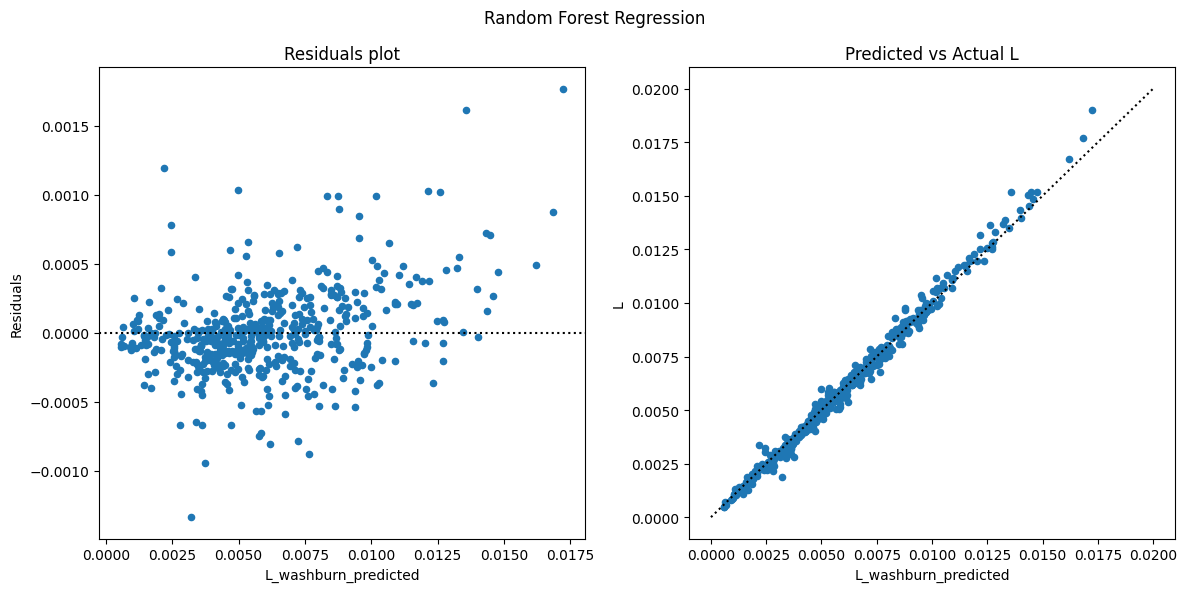

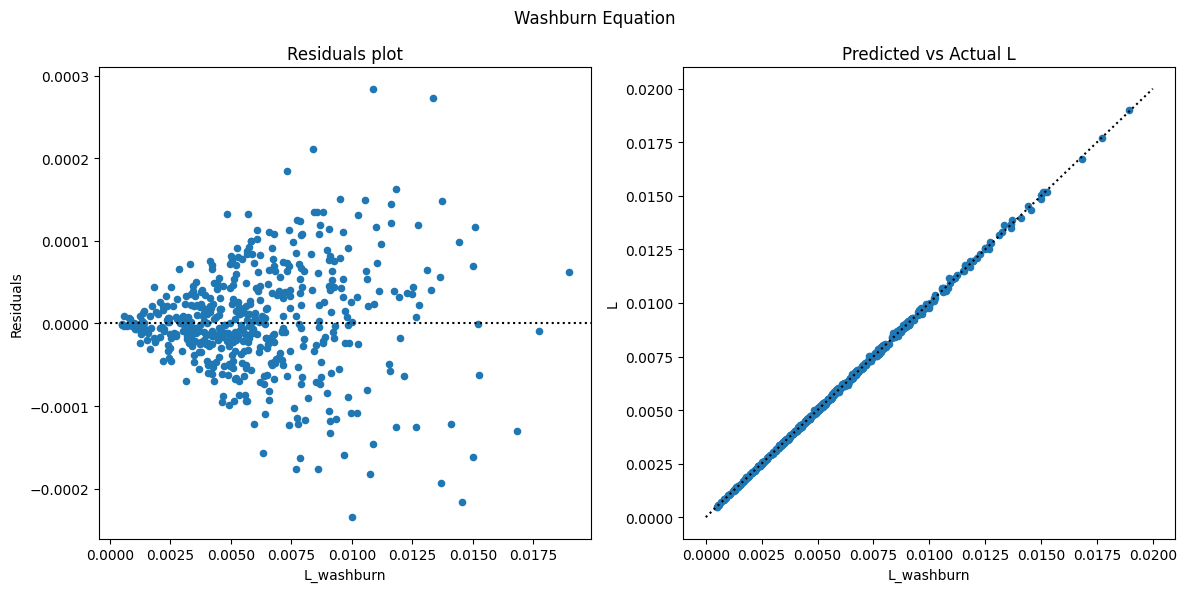

############# Evaluation metrics ###############
model: RF
Correlation coefficient: 0.9956005993120003
Mean Squared Error: 1.0146651558193394e-07
R^2 Score: 0.989947890565648
Mean absolute error: 0.00022307909491256224
Root mean squared error: 0.0003185380912574412
Relative absolute error: 0.08950225033850319
Root relative squared error: 0.10026020862910684 

############# Evaluation metrics ###############
model: Washburn
Correlation coefficient: 0.9997960765847599
Mean Squared Error: 4.1405906865926404e-09
R^2 Score: 0.9995897989551944
Mean absolute error: 4.636394889666097e-05
Root mean squared error: 6.434742175559671e-05
Relative absolute error: 0.01860182265154438
Root relative squared error: 0.020253420570499964 



In [63]:
# Continue with chosen model 
opt_model_regression = rf_pipeline_scaled
# Predict the L_washburn values using the best model

microscopy_data["L_washburn_predicted"] = opt_model_regression.predict(microscopy_data[['gamma', 'r', 't', 'phi', 'eta']])
microscopy_data["L_washburn_residuals_predicted"] = microscopy_data["L"] - microscopy_data["L_washburn_predicted"]

fig, axs = plt.subplots(1, 2, figsize = (12,6))
                       
# Plot the residuals
microscopy_data.plot(ax=axs[0], x='L_washburn_predicted', y='L_washburn_residuals_predicted', kind='scatter')
plt.xlabel('L')
axs[0].axhline(y=0.0, color='black', linestyle='dotted')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residuals plot')

microscopy_data.plot(ax= axs[1], x='L_washburn_predicted', y='L', kind='scatter')
axs[1].set_title("Predicted vs Actual L")
# plot x=y
plt.plot([0, 0.02], [0, 0.02], color='black', linestyle='dotted')

fig.suptitle("Random Forest Regression")
plt.tight_layout()
plt.show()

# Plotting for Washburn equation
fig, axs = plt.subplots(1, 2, figsize = (12,6))
                       
# Plot the residuals
microscopy_data.plot(ax=axs[0], x='L_washburn', y='L_washburn_residuals', kind='scatter')
plt.xlabel('L')
axs[0].axhline(y=0.0, color='black', linestyle='dotted')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residuals plot')

microscopy_data.plot(ax= axs[1], x='L_washburn', y='L', kind='scatter')
axs[1].set_title("Predicted vs Actual L")
# plot x=y
plt.plot([0, 0.02], [0, 0.02], color='black', linestyle='dotted')

fig.suptitle("Washburn Equation")
plt.tight_layout()
plt.show()

evaluation_metrics("RF", microscopy_data["L"], microscopy_data["L_washburn_predicted"])
evaluation_metrics("Washburn", microscopy_data["L"], microscopy_data["L_washburn"])


In [ ]:
# Not an optimal model, the Washburn equation performs better 

# Possible improvements:
    # Maybe tuned linear regression? 
    # Removing the outliers in the dataset?

# Time resolved datasets

An investigation into the time resolved datasets, begins with classification of each dataset

In [ ]:
# Variables:
    # L: the distance that the fluid travels into the solid
    # dL: the residuals of the distance that the fluid travels into the solid
    # t: the time at which measurement is taken 

# Predict the biscuit type of each dataset tr1, tr2, tr3